# ML testing: experiment #1d- harmonized on Autocombat algorithm,

This notebook involves testing for the MRI conference abstract. This notebook shows harmonized StrokeMRI and TOP based models, and how they perform on each other

### import libraries

In [1]:
import os       # using operating system dependent functionality (folders)
import sys
import glob
from functools import reduce

import pandas as pd # data analysis and manipulation
import numpy as np    # numerical computing (manipulating and performing operations on arrays of data)
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interactive
import seaborn as sns

# ml stuff
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import tree
from sklearn import metrics
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import ExtraTreesRegressor
import joblib

sys.path.insert(0, '../') # path to functions
import cvasl.seperated as sep
from cvasl.file_handler import Config
import cvasl.harmony as har

### import data , clean and prep

In [2]:
filepath_mri = '../open_work/internal_results/autocombat' 
filename_mri = os.path.join(filepath_mri,'autocom_harm_mri1.csv')

filepath_top = '../open_work/internal_results/autocombat' 

filename_top = os.path.join(filepath_mri,'autocom_harm_top1.csv') 
TOP = pd.read_csv(filename_top)
StrokeMRI = pd.read_csv(filename_mri)
TOP = TOP.drop(TOP.columns[0],axis=1)
StrokeMRI = StrokeMRI.drop(StrokeMRI.columns[0],axis=1)


TOP.head(3)

,participant_id,age,sex,gm_vol,wm_vol,csf_vol,gm_ivc_ratio,gmwm_ivc_ratio,wmh_vol,wmh_count,deepwm_b_cov,aca_b_cov,mca_b_cov,pca_b_cov,totalgm_b_cov,deepwm_b,aca_b,mca_b,pca_b,totalgm_b
0,sub-0001_1_ses-1_run-1,43.49,1,0.718674,0.528496,0.319685,0.458286,0.795431,-1.039874,24.763992,8.516114,2.360053,2.377184,2.901084,2.503354,22.772817,80.884896,69.387688,53.476437,61.913060
1,sub-0002_1_ses-1_run-1,38.30,0,0.724979,0.623653,0.253076,0.450509,0.841868,-1.271561,23.046569,8.820316,1.732756,2.465251,1.552402,1.970691,23.839071,86.946443,77.573116,63.390347,71.064192
2,sub-0019_1_ses-1_run-1,32.30,1,0.713685,0.533377,0.339021,0.449842,0.785814,-3.320162,5.872341,8.629959,2.009376,1.871359,2.255016,2.201651,26.817967,92.802664,84.605919,62.193642,73.123293


In [3]:
StrokeMRI.head(3)

,participant_id,age,sex,gm_vol,wm_vol,csf_vol,gm_ivc_ratio,gmwm_ivc_ratio,wmh_vol,wmh_count,deepwm_b_cov,aca_b_cov,mca_b_cov,pca_b_cov,totalgm_b_cov,deepwm_b,aca_b,mca_b,pca_b,totalgm_b
0,sub-59082_1_ses-1_run-1,43.172603,0,0.644124,0.493658,0.312204,0.445676,0.786369,2.003323,23.711215,8.294363,1.745254,1.966548,1.724103,1.922505,30.192832,108.569928,95.349592,77.480129,89.775444
1,sub-59083_1_ses-1_run-1,66.367123,0,0.600559,0.485119,0.414406,0.400875,0.725977,12.018041,24.483432,3.911043,1.953406,1.728619,2.518101,1.893640,25.559621,74.092655,62.324683,67.222466,66.808119
2,sub-59085_1_ses-1_run-1,55.838356,0,0.612969,0.537391,0.334274,0.414744,0.776399,5.823741,28.344518,5.294302,1.821096,1.972809,2.040398,1.954568,32.390907,80.589741,72.408213,61.160227,63.102088


## choose whether to log columns

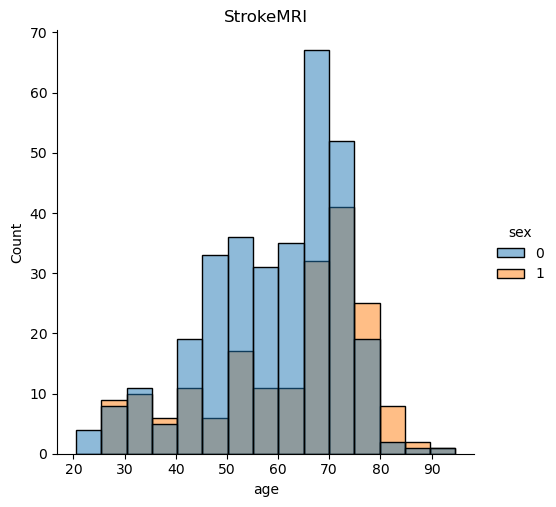

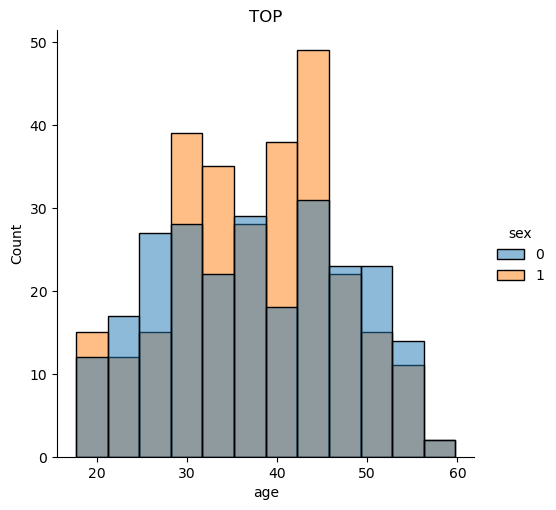

interactive(children=(Dropdown(description='feature', index=1, options=('participant_id', 'age', 'sex', 'gm_vo…

In [4]:
# examine distributions visually
possibilities = StrokeMRI.columns.to_list()
def see_feature_on_two(a):
    sns.displot(StrokeMRI, x= a, hue= 'sex'), plt.title('StrokeMRI')
    sns.displot(TOP, x= a, hue= 'sex'), plt.title('TOP')
    return a
w = interactive(see_feature_on_two,
                a=widgets.Dropdown(
                    options= possibilities,
                    value='age',
                    description='feature',
                    disabled=False))
w

In [5]:
data = StrokeMRI
features_to_log = widgets.SelectMultiple(
    options=data.columns.tolist(),
    value=[],
    description='Features',
    disabled=False
)
features_to_log

SelectMultiple(description='Features', options=('participant_id', 'age', 'sex', 'gm_vol', 'wm_vol', 'csf_vol',…

In [6]:
list(features_to_log.value)

[]

In [7]:
if len(features_to_log.value) == 0:
    output_folder = '1d_no_log_outputs'
else:
    output_folder = '1d_loged_outputs'

os.makedirs(output_folder, exist_ok=True)

In [8]:
StrokeMRI = har.log_out_columns(StrokeMRI, list(features_to_log.value))
TOP = har.log_out_columns(TOP, list(features_to_log.value))

## add binned column on age

In [9]:
!python --version

Python 3.11.6


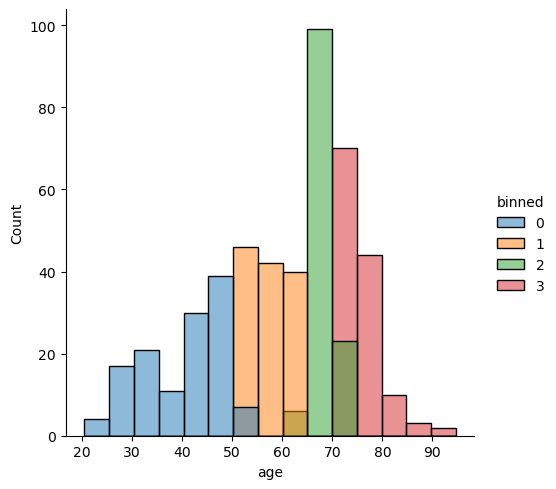

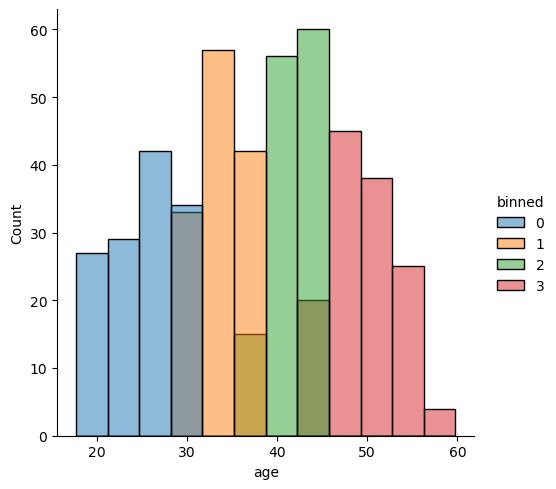

In [10]:
StrokeMRI = sep.bin_dataset(StrokeMRI, 'age', num_bins=4, graph = True)
TOP =  sep.bin_dataset(TOP, 'age', num_bins=4, graph = True)

## Build ML models based on StrokeMRI

In [11]:
ml_matrix = StrokeMRI.drop('participant_id', axis=1)
X = ml_matrix.drop('age', axis =1)
X = X.values
X = X.astype('float')
y = ml_matrix['age'].values
y=y.astype('float')


In [12]:
linr_k_frame, linr_y_frame, models = sep.stratified_one_category_shuffle_split('linear regression', 'autoharm_mri_linr', LinearRegression(), ml_matrix, X, y, printed=True)


Fold 0:
Train shapes: X (385, 19)  y (385,)
Category classes: [0 1] percentages: [63.11688312 36.88311688]

Test shapes: X (129, 19)   y (129,)
Category classes: [0 1],percentages: [62.79069767 37.20930233]

Fold 1:
Train shapes: X (385, 19)  y (385,)
Category classes: [0 1] percentages: [63.11688312 36.88311688]

Test shapes: X (129, 19)   y (129,)
Category classes: [0 1],percentages: [62.79069767 37.20930233]

Fold 2:
Train shapes: X (385, 19)  y (385,)
Category classes: [0 1] percentages: [63.11688312 36.88311688]

Test shapes: X (129, 19)   y (129,)
Category classes: [0 1],percentages: [62.79069767 37.20930233]

Fold 3:
Train shapes: X (385, 19)  y (385,)
Category classes: [0 1] percentages: [63.11688312 36.88311688]

Test shapes: X (129, 19)   y (129,)
Category classes: [0 1],percentages: [62.79069767 37.20930233]

Fold 4:
Train shapes: X (385, 19)  y (385,)
Category classes: [0 1] percentages: [63.11688312 36.88311688]

Test shapes: X (129, 19)   y (129,)
Category classes: [0 1]

C:\Projects\cvasl\harmonization_paper\..\cvasl\seperated.py:890: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_results = pd.concat([mod_results, mod_results_current_fold])
C:\Projects\cvasl\harmonization_paper\..\cvasl\seperated.py:890: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_results = pd.concat([mod_results, mod_results_current_fold])
C:\Projects\cvasl\harmonization_paper\..\cvasl\seperated.py:890: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries

In [13]:
linr_k_frame

,algorithm,fold,file_name,mae,r2,explained_variance
0,linear regression-0,0,autoharm_mri_linr.0,3.758647,0.880729,0.880730
0,linear regression-1,1,autoharm_mri_linr.1,3.354859,0.911962,0.912113
0,linear regression-2,2,autoharm_mri_linr.2,3.494059,0.878726,0.880661
0,linear regression-3,3,autoharm_mri_linr.3,3.430112,0.890249,0.893611
0,linear regression-4,4,autoharm_mri_linr.4,3.657742,0.881851,0.882955


In [14]:
linr_k_frame.to_csv(output_folder + '/autoharmonized_mri_linr_k_frame.csv')

In [15]:
avg_linr = sep.avg_k_folds(linr_k_frame)
avg_linr

,algorithm,file_name,mae,r2,explained_variance
0,0 linear regression-0 0 linear regressio...,0 autoharm_mri_linr.0 0 autoharm_mri_lin...,3.539084,0.888703,0.890014


In [16]:
linr_y_frame

,y_test,y_pred
0,50.797260,54.464573
1,77.601093,80.517469
2,66.041096,60.722700
3,71.479452,75.300916
4,72.630137,81.204270
...,...,...
124,72.331507,78.741216
125,50.918819,49.553530
126,70.180328,60.814468
127,42.016393,43.944322


In [17]:
linr_y_frame.to_csv(output_folder +'/autoharmonized_mri_linr_y_frame.csv')

In [18]:
linr = models[0]
linr[0]

LinearRegression()

In [19]:
#models

In [20]:
# check if model folder exists and if not , then create
model_folder = 'result_models/'
if not os.path.exists(output_folder + model_folder):
    os.makedirs(output_folder + model_folder)

In [21]:
## optional save models
#joblib.dump(linr[0], ('../result_models/'+ 'autoharm_mri_linr0.sav'))
#joblib.dump(linr[1], ('../result_models/'+ 'autoharm_mri_linr1.sav'))
#joblib.dump(linr[2], ('../result_models/'+ 'autoharm_mri_linr2.sav'))
#joblib.dump(linr[3], ('../result_models/'+ 'autoharm_mri_linr3.sav'))
#joblib.dump(linr[4], ('../result_models/'+ 'autoharm_mri_linr4.sav'))

In [22]:
llreg_k_frame, llreg_y_frame, models =  sep.stratified_one_category_shuffle_split('lasso regression', 'autoharm_mri_llreg',  linear_model.LassoLars(alpha=0.01), ml_matrix, X, y)
llreg_k_frame

C:\Projects\cvasl\harmonization_paper\..\cvasl\seperated.py:890: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_results = pd.concat([mod_results, mod_results_current_fold])
C:\Projects\cvasl\harmonization_paper\..\cvasl\seperated.py:890: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_results = pd.concat([mod_results, mod_results_current_fold])
C:\Projects\cvasl\harmonization_paper\..\cvasl\seperated.py:890: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries

,algorithm,fold,file_name,mae,r2,explained_variance
0,lasso regression-0,0,autoharm_mri_llreg.0,3.684309,0.880205,0.880206
0,lasso regression-1,1,autoharm_mri_llreg.1,3.311211,0.910842,0.910891
0,lasso regression-2,2,autoharm_mri_llreg.2,3.295762,0.890368,0.893149
0,lasso regression-3,3,autoharm_mri_llreg.3,3.379981,0.889708,0.894052
0,lasso regression-4,4,autoharm_mri_llreg.4,3.496536,0.888058,0.888852


In [23]:
llreg_k_frame.to_csv(output_folder +'/autoharmonized_mri_llreg_k_frame.csv')

In [24]:
avg_llreg = sep.avg_k_folds(llreg_k_frame)
avg_llreg

,algorithm,file_name,mae,r2,explained_variance
0,0 lasso regression-0 0 lasso regression-...,0 autoharm_mri_llreg.0 0 autoharm_mri_ll...,3.43356,0.891836,0.89343


In [25]:
llreg_y_frame

,y_test,y_pred
0,50.797260,54.691600
1,77.601093,80.145888
2,66.041096,62.528594
3,71.479452,75.679000
4,72.630137,80.908351
...,...,...
124,72.331507,78.295075
125,50.918819,50.261338
126,70.180328,60.937217
127,42.016393,43.795024


In [26]:
llreg_y_frame.to_csv(output_folder +'/autoharmonized_mri_llreg_y_frame.csv')

In [27]:
llreg = models[0]
llreg[0]

LassoLars(alpha=0.01)

In [28]:
## optional save models
#joblib.dump(llreg[0], ('../result_models/'+ 'autoharm_mri_llreg0.sav'))
#joblib.dump(llreg[1], ('../result_models/'+ 'autoharm_mri_llreg1.sav'))
#joblib.dump(llreg[2], ('../result_models/'+ 'autoharm_mri_llreg2.sav'))
#joblib.dump(llreg[3], ('../result_models/'+ 'autoharm_mri_llreg3.sav'))
#joblib.dump(llreg[4], ('../result_models/'+ 'autoharm_mri_llreg4.sav'))

In [29]:
dtree_k_frame, dtree_y_frame, models = sep.stratified_one_category_shuffle_split('decision tree', 'autoharm_mri_dtree',  tree.DecisionTreeRegressor(), ml_matrix, X, y)
dtree_k_frame

C:\Projects\cvasl\harmonization_paper\..\cvasl\seperated.py:890: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_results = pd.concat([mod_results, mod_results_current_fold])
C:\Projects\cvasl\harmonization_paper\..\cvasl\seperated.py:890: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_results = pd.concat([mod_results, mod_results_current_fold])
C:\Projects\cvasl\harmonization_paper\..\cvasl\seperated.py:890: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries

,algorithm,fold,file_name,mae,r2,explained_variance
0,decision tree-0,0,autoharm_mri_dtree.0,3.370236,0.869115,0.869760
0,decision tree-1,1,autoharm_mri_dtree.1,3.704775,0.877583,0.877594
0,decision tree-2,2,autoharm_mri_dtree.2,3.623890,0.846640,0.846641
0,decision tree-3,3,autoharm_mri_dtree.3,3.553119,0.851963,0.853478
0,decision tree-4,4,autoharm_mri_dtree.4,3.663166,0.846102,0.846290


In [30]:
dtree_k_frame.to_csv(output_folder +'/autoharmonized_mri_dtree_k_frame.csv')

In [31]:
avg_dtree = sep.avg_k_folds(dtree_k_frame)
avg_dtree

,algorithm,file_name,mae,r2,explained_variance
0,0 decision tree-0 0 decision tree-1 0 ...,0 autoharm_mri_dtree.0 0 autoharm_mri_dt...,3.583037,0.858281,0.858753


In [32]:
dtree_y_frame

,y_test,y_pred
0,50.797260,56.008219
1,77.601093,79.210959
2,66.041096,67.013699
3,71.479452,74.769863
4,72.630137,76.117808
...,...,...
124,72.331507,74.393443
125,50.918819,50.668493
126,70.180328,65.375342
127,42.016393,47.583562


In [33]:
dtree_y_frame.to_csv(output_folder +'/autoharmonized_mri_dtree_y_frame.csv')

In [34]:
dtree = models[0]
dtree[0]

DecisionTreeRegressor()

In [35]:
regr_k_frame, regr_y_frame, models = sep.stratified_one_category_shuffle_split('MLP regression', 'autoharm_mri_regr',   MLPRegressor(random_state=1, max_iter=700), ml_matrix, X, y)
regr_k_frame

C:\Users\CandaceMoore\miniconda3\envs\mriland\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Projects\cvasl\harmonization_paper\..\cvasl\seperated.py:890: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_results = pd.concat([mod_results, mod_results_current_fold])
C:\Users\CandaceMoore\miniconda3\envs\mriland\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Projects\cvasl\harmonization_paper\..\cvasl\seperated.py:890: Fut

,algorithm,fold,file_name,mae,r2,explained_variance
0,MLP regression-0,0,autoharm_mri_regr.0,4.126494,0.831188,0.831310
0,MLP regression-1,1,autoharm_mri_regr.1,3.971341,0.864616,0.875897
0,MLP regression-2,2,autoharm_mri_regr.2,3.938671,0.838861,0.863607
0,MLP regression-3,3,autoharm_mri_regr.3,3.881570,0.831842,0.837924
0,MLP regression-4,4,autoharm_mri_regr.4,4.299013,0.832542,0.832580


In [36]:
regr_k_frame.to_csv(output_folder +'/autoharmonized_mri_regr_k_frame.csv')

In [37]:
avg_regr = sep.avg_k_folds(regr_k_frame)
avg_regr

,algorithm,file_name,mae,r2,explained_variance
0,0 MLP regression-0 0 MLP regression-1 0 ...,0 autoharm_mri_regr.0 0 autoharm_mri_reg...,4.043418,0.83981,0.848263


In [38]:
regr_y_frame

,y_test,y_pred
0,50.797260,48.664169
1,77.601093,76.733076
2,66.041096,63.969489
3,71.479452,76.743052
4,72.630137,90.581422
...,...,...
124,72.331507,77.035335
125,50.918819,47.373584
126,70.180328,64.385324
127,42.016393,41.460301


In [39]:
regr_y_frame.to_csv(output_folder +'/autoharmonized_mri_regr_y_frame.csv')

In [40]:
regr = models[0]
regr[0]

MLPRegressor(max_iter=700, random_state=1)

### Note I'm not actually saving the mlp or svr models here because they are not the best performers. if neccesary this can be added

In [41]:
svrp2_k_frame, svrp2_y_frame, models = sep.stratified_one_category_shuffle_split('support vector reg poly2', 'uautoharm_mri_svrp2',   SVR(C=1.0, kernel='poly', degree =2, epsilon=0.2), ml_matrix, X, y)
svrp2_k_frame

C:\Projects\cvasl\harmonization_paper\..\cvasl\seperated.py:890: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_results = pd.concat([mod_results, mod_results_current_fold])
C:\Projects\cvasl\harmonization_paper\..\cvasl\seperated.py:890: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_results = pd.concat([mod_results, mod_results_current_fold])
C:\Projects\cvasl\harmonization_paper\..\cvasl\seperated.py:890: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries

,algorithm,fold,file_name,mae,r2,explained_variance
0,support vector reg poly2-0,0,uautoharm_mri_svrp2.0,9.013130,0.311965,0.316986
0,support vector reg poly2-1,1,uautoharm_mri_svrp2.1,8.332646,0.414825,0.472036
0,support vector reg poly2-2,2,uautoharm_mri_svrp2.2,8.069116,0.422810,0.426070
0,support vector reg poly2-3,3,uautoharm_mri_svrp2.3,7.805722,0.407489,0.408422
0,support vector reg poly2-4,4,uautoharm_mri_svrp2.4,8.043228,0.414575,0.430075


In [42]:
svrp2_k_frame.to_csv(output_folder +'/autoharmonized_mri_svrp2_k_frame.csv')

In [43]:
avg_svrp2 = sep.avg_k_folds(svrp2_k_frame)
avg_svrp2

,algorithm,file_name,mae,r2,explained_variance
0,0 support vector reg poly2-0 0 support v...,0 uautoharm_mri_svrp2.0 0 uautoharm_mri_...,8.252769,0.394333,0.410718


In [44]:
svrp2_y_frame

,y_test,y_pred
0,50.797260,63.900474
1,77.601093,66.105339
2,66.041096,58.488487
3,71.479452,63.564916
4,72.630137,69.213142
...,...,...
124,72.331507,64.846581
125,50.918819,58.353787
126,70.180328,49.116964
127,42.016393,62.364162


In [45]:
svrp2_y_frame.to_csv(output_folder +'/autoharmonized_mrisvrp2_y_frame.csv')

In [46]:
svrp2 = models[0]
svrp2[0]

SVR(degree=2, epsilon=0.2, kernel='poly')

In [47]:
eregr_k_frame, eregr_y_frame, models = sep.stratified_one_category_shuffle_split('elasticnetCV', 'autoharm_mix_eregr',  ElasticNetCV(cv=5, random_state=12), ml_matrix, X, y)
eregr_k_frame

C:\Projects\cvasl\harmonization_paper\..\cvasl\seperated.py:890: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_results = pd.concat([mod_results, mod_results_current_fold])
C:\Projects\cvasl\harmonization_paper\..\cvasl\seperated.py:890: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_results = pd.concat([mod_results, mod_results_current_fold])
C:\Projects\cvasl\harmonization_paper\..\cvasl\seperated.py:890: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries

,algorithm,fold,file_name,mae,r2,explained_variance
0,elasticnetCV-0,0,autoharm_mix_eregr.0,4.099768,0.848881,0.849046
0,elasticnetCV-1,1,autoharm_mix_eregr.1,3.661686,0.884815,0.884821
0,elasticnetCV-2,2,autoharm_mix_eregr.2,3.523501,0.876564,0.884503
0,elasticnetCV-3,3,autoharm_mix_eregr.3,3.859477,0.846533,0.853368
0,elasticnetCV-4,4,autoharm_mix_eregr.4,3.921096,0.861443,0.861457


In [48]:
eregr_k_frame.to_csv(output_folder +'/autoharmonized_eregr_k_frame.csv')

In [49]:
avg_eregr = sep.avg_k_folds(eregr_k_frame)
avg_eregr

,algorithm,file_name,mae,r2,explained_variance
0,0 elasticnetCV-0 0 elasticnetCV-1 0 e...,0 autoharm_mix_eregr.0 0 autoharm_mix_er...,3.813105,0.863647,0.866639


In [50]:
eregr_y_frame

,y_test,y_pred
0,50.797260,53.879948
1,77.601093,78.925651
2,66.041096,64.681426
3,71.479452,73.519644
4,72.630137,75.833309
...,...,...
124,72.331507,77.031386
125,50.918819,50.243755
126,70.180328,60.235090
127,42.016393,45.526651


In [51]:
eregr_y_frame.to_csv(output_folder +'/autoharmonized_mri_eregr_y_frame.csv')

In [52]:
eregr = models[0]
eregr[0]

ElasticNetCV(cv=5, random_state=12)

In [53]:
etreg_k_frame, etreg_y_frame, models = sep.stratified_one_category_shuffle_split('extra trees', 'autoharm_mri_etreg',  ExtraTreesRegressor(n_estimators=100, random_state=0), ml_matrix, X, y)
etreg_k_frame

C:\Projects\cvasl\harmonization_paper\..\cvasl\seperated.py:890: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_results = pd.concat([mod_results, mod_results_current_fold])
C:\Projects\cvasl\harmonization_paper\..\cvasl\seperated.py:890: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_results = pd.concat([mod_results, mod_results_current_fold])
C:\Projects\cvasl\harmonization_paper\..\cvasl\seperated.py:890: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries

,algorithm,fold,file_name,mae,r2,explained_variance
0,extra trees-0,0,autoharm_mri_etreg.0,2.795634,0.923755,0.924029
0,extra trees-1,1,autoharm_mri_etreg.1,2.972281,0.922494,0.922663
0,extra trees-2,2,autoharm_mri_etreg.2,2.621183,0.915717,0.915790
0,extra trees-3,3,autoharm_mri_etreg.3,2.457500,0.934086,0.934099
0,extra trees-4,4,autoharm_mri_etreg.4,3.154535,0.898240,0.899822


In [54]:
etreg_k_frame.to_csv(output_folder +'/autoharomized_etreg_k_frame.csv')

In [55]:
avg_etreg = sep.avg_k_folds(etreg_k_frame)
avg_etreg

,algorithm,file_name,mae,r2,explained_variance
0,0 extra trees-0 0 extra trees-1 0 ext...,0 autoharm_mri_etreg.0 0 autoharm_mri_et...,2.800226,0.918858,0.919281


In [56]:
etreg_y_frame

,y_test,y_pred
0,50.797260,56.612364
1,77.601093,75.960671
2,66.041096,66.452738
3,71.479452,74.505140
4,72.630137,76.447444
...,...,...
124,72.331507,74.141228
125,50.918819,55.820586
126,70.180328,66.210537
127,42.016393,43.613887


In [57]:
etreg_y_frame.to_csv(output_folder +'/autoharmonized_etreg_y_frame.csv')

In [58]:
etreg = models[0]
etreg[0]

ExtraTreesRegressor(random_state=0)

In [59]:
## optional save models
#joblib.dump(etreg[0], ('../result_models/'+ 'autoharm_mri_etreg0.sav'))
#joblib.dump(etreg[1], ('../result_models/'+ 'autoharm_mri_etreg1.sav'))
#joblib.dump(etreg[2], ('../result_models/'+ 'autoharm_mri_etreg2.sav'))
#joblib.dump(etreg[3], ('../result_models/'+ 'autoharm_mri_etreg3.sav'))
#joblib.dump(etreg[4], ('../result_models/'+ 'autoharm_mri_etreg4.sav'))

Show results ON AVERAGE for each model

In [60]:
mri_based_autoharmonized_on_testmri =pd.concat([avg_linr,
                   avg_llreg,
                   avg_dtree,
                   avg_regr,
                   avg_svrp2,
                   avg_eregr,
                   avg_etreg],
                  axis=0)
mri_based_autoharmonized_on_testmri

,algorithm,file_name,mae,r2,explained_variance
0,0 linear regression-0 0 linear regressio...,0 autoharm_mri_linr.0 0 autoharm_mri_lin...,3.539084,0.888703,0.890014
0,0 lasso regression-0 0 lasso regression-...,0 autoharm_mri_llreg.0 0 autoharm_mri_ll...,3.433560,0.891836,0.893430
0,0 decision tree-0 0 decision tree-1 0 ...,0 autoharm_mri_dtree.0 0 autoharm_mri_dt...,3.583037,0.858281,0.858753
0,0 MLP regression-0 0 MLP regression-1 0 ...,0 autoharm_mri_regr.0 0 autoharm_mri_reg...,4.043418,0.839810,0.848263
0,0 support vector reg poly2-0 0 support v...,0 uautoharm_mri_svrp2.0 0 uautoharm_mri_...,8.252769,0.394333,0.410718
0,0 elasticnetCV-0 0 elasticnetCV-1 0 e...,0 autoharm_mix_eregr.0 0 autoharm_mix_er...,3.813105,0.863647,0.866639
0,0 extra trees-0 0 extra trees-1 0 ext...,0 autoharm_mri_etreg.0 0 autoharm_mri_et...,2.800226,0.918858,0.919281


In [61]:
mri_based_autoharmonized_on_testmri.to_csv(output_folder + '/mri_based_autoharmonized_on_testmri_AVERAGES.csv')

## Now we will build  models based on the whole auto-harmonized StrokeMRI dataset, and apply them to TOP. 

In [62]:
ml_matrix = StrokeMRI.drop('participant_id', axis=1)
X = ml_matrix.drop('age', axis =1)
X = X.values
X = X.astype('float')
y = ml_matrix['age'].values
y=y.astype('float')


In [63]:
# now we decide to do no test train split, rather take all
X_train = X
y_train = y

In [64]:
MRIlinr = LinearRegression()
MRIlinr.fit(X_train, y_train)

LinearRegression()

In [65]:
MRIllreg = linear_model.LassoLars(alpha=0.01)
MRIllreg.fit(X_train, y_train)

LassoLars(alpha=0.01)

In [66]:
MRIeregr = ElasticNetCV(cv=5, random_state=17)
MRIeregr.fit(X_train, y_train)


ElasticNetCV(cv=5, random_state=17)

In [67]:
MRIetreg = ExtraTreesRegressor(n_estimators=100, random_state=0)
MRIetreg.fit(X_train, y_train)

ExtraTreesRegressor(random_state=0)

In [68]:
##  Save these four best models

In [69]:

## optional save models
#joblib.dump(MRIlinr, ('../result_models/' + 'autoharm_whole_mri_linr.sav'))
#joblib.dump(MRIllreg, ('../result_models/'+ 'autoharm_whole_mri_llreg1.sav'))
#joblib.dump(MRIeregr, ('../result_models/'+ 'autoharm_whole_mri_eregr3.sav'))
#joblib.dump(MRIetreg, ('../result_models/'+ 'autoharm_whole_mri_etreg4.sav'))

# Running whole MRI model over TOP dataset

In [70]:
top_ml_matrix = TOP.drop('participant_id', axis=1)
X_top = top_ml_matrix.drop('age', axis =1)
X_top = X_top.values
X_top = X_top.astype('float')
y_top = top_ml_matrix['age'].values
y_top=y_top.astype('float')

In [71]:
X_top_test = X_top
y_top_test = y_top


In [72]:
y_top_pred = MRIlinr.predict(X_top_test)

In [73]:
# print('R2 score Linear regression: %.3f' % linr.score(X_top_test,y_top_test))
# print('Explained variance score: %.3f'  % metrics.explained_variance_score(y_top_test, y_top_pred))
# print('The mean absolute error: %.3f' % mean_absolute_error(y_top_test, y_top_pred))

In [74]:
data= [[
    'linear regression',
    'autoharm_whole_mri_linr.sav',
    mean_absolute_error(y_top_test, y_top_pred),
    MRIlinr.score(X_top_test,y_top_test),
    metrics.explained_variance_score(y_top_test, y_top_pred)]]
linr_results = pd.DataFrame(data, columns=['algorithm','file_name','mae', 'r2', 'explained_variance'])
#linr_results

In [75]:
linr_y_test = y_top_test
linr_y_pred = y_top_pred
linr_compare = pd.DataFrame(
    {'y_test_real_age': linr_y_test,
     'linr_y_pred_age': linr_y_pred,
    })
linr_compare = linr_compare.reset_index()
linr_compare

,index,y_test_real_age,linr_y_pred_age
0,0,43.49,56.471176
1,1,38.30,57.762126
2,2,32.30,49.021190
3,3,21.97,38.999747
4,4,37.52,48.963756
...,...,...,...
522,522,19.06,33.143220
523,523,33.86,46.325967
524,524,33.92,51.766238
525,525,45.31,68.236373


In [76]:
linr_compare.to_csv(output_folder +'/whole_mri_linr_compare_on_top.csv')

In [77]:
y_top_pred = MRIllreg.predict(X_top_test)

In [78]:
data= [[
    'lasso regression',
    'autoharm_whole_mri_llreg.sav',
    mean_absolute_error(y_top_test, y_top_pred),
    MRIllreg.score(X_top_test,y_top_test),
    metrics.explained_variance_score(y_top_test, y_top_pred)]]
llreg_results = pd.DataFrame(data, columns=['algorithm','file_name','mae', 'r2', 'explained_variance'])
llreg_results

,algorithm,file_name,mae,r2,explained_variance
0,lasso regression,autoharm_whole_mri_llreg.sav,16.189378,-2.02656,0.844912


In [79]:
llreg_y_test = y_top_test
llreg_y_pred = y_top_pred
llreg_compare = pd.DataFrame(
    {'y_test_real_age': llreg_y_test,
     'linr_y_pred_age': llreg_y_pred,
    })
#llreg_compare = llreg_compare.reset_index()
llreg_compare

,y_test_real_age,linr_y_pred_age
0,43.49,57.318348
1,38.30,57.393534
2,32.30,49.181012
3,21.97,41.034316
4,37.52,49.369352
...,...,...
522,19.06,34.649316
523,33.86,47.358663
524,33.92,52.250585
525,45.31,68.582218


In [80]:
llreg_compare.to_csv(output_folder +'/auto_whole_mri_llreg_compare_on_top.csv')

In [81]:
y_top_pred = MRIeregr.predict(X_top_test)

In [82]:
data= [[
    'elasticnetCV',
    'autoharm_whole_mri_linr.sav',
    mean_absolute_error(y_top_test, y_top_pred),
    MRIeregr.score(X_top_test,y_top_test),
    metrics.explained_variance_score(y_top_test, y_top_pred)]]
eregr_results = pd.DataFrame(data, columns=['algorithm','file_name','mae', 'r2', 'explained_variance'])
#eregr_results

In [83]:
eregr_y_test = y_top_test
eregr_y_pred = y_top_pred
eregr_compare = pd.DataFrame(
    {'y_test_real_age': eregr_y_test,
     'linr_y_pred_age': eregr_y_pred,
    })
#eregr_compare = eregr_compare.reset_index()
eregr_compare

,y_test_real_age,linr_y_pred_age
0,43.49,59.268012
1,38.30,56.883950
2,32.30,49.673061
3,21.97,45.815908
4,37.52,51.683267
...,...,...
522,19.06,40.237703
523,33.86,49.612209
524,33.92,55.239566
525,45.31,64.364578


In [84]:
eregr_compare.to_csv(output_folder +'/auto_whole_mri_eregr_compare_on_top.csv')

In [85]:
y_top_pred = MRIetreg.predict(X_top_test)

In [86]:
data= [[
    'extra trees',
    'autoharm_mri_linr.sav',
    mean_absolute_error(y_top_test, y_top_pred),
    MRIetreg.score(X_top_test,y_top_test),
    metrics.explained_variance_score(y_top_test, y_top_pred)]]
etreg_results = pd.DataFrame(data, columns=['algorithm','file_name','mae', 'r2', 'explained_variance'])
#etreg_results

In [87]:
etreg_y_test = y_top_test
etreg_y_pred = y_top_pred
etreg_compare = pd.DataFrame(
    {'y_test_real_age': etreg_y_test,
     'linr_y_pred_age': etreg_y_pred,
    })
#etreg_compare = etreg_compare.reset_index()
etreg_compare

,y_test_real_age,linr_y_pred_age
0,43.49,66.093245
1,38.30,65.714269
2,32.30,54.364411
3,21.97,34.827528
4,37.52,53.000891
...,...,...
522,19.06,29.954345
523,33.86,53.740249
524,33.92,55.852009
525,45.31,73.895072


In [88]:
etreg_compare.to_csv(output_folder +'/autowhole_mri_etreg_compare_on_top.csv')

In [89]:
mri_based_autoharmonized_on_top =pd.concat([linr_results,
                   llreg_results,
                   eregr_results,
                  etreg_results],
                  axis=0)
mri_based_autoharmonized_on_top

,algorithm,file_name,mae,r2,explained_variance
0,linear regression,autoharm_whole_mri_linr.sav,15.674792,-1.850451,0.841381
0,lasso regression,autoharm_whole_mri_llreg.sav,16.189378,-2.026560,0.844912
0,elasticnetCV,autoharm_whole_mri_linr.sav,17.095936,-2.325401,0.876664
0,extra trees,autoharm_mri_linr.sav,18.996082,-3.620653,0.316317


## Now we will run the exact opposite process.
1. We will explore TOP based models via k-folded results, 
2. We will make a general unahrmonized TOP model (based off all TOP)
3. We will apply the best of these model to the StrokeMRI dataset

### Build ML models based on TOP

In [90]:
ml_matrix = TOP.drop('participant_id', axis=1)
X = ml_matrix.drop('age', axis =1)
X = X.values
X = X.astype('float')
y = ml_matrix['age'].values
y=y.astype('float')


In [91]:
linr_k_frame, linr_y_frame, models = sep.stratified_one_category_shuffle_split('linear regression', 'autoharm_top_linr', LinearRegression(), ml_matrix, X, y)

C:\Projects\cvasl\harmonization_paper\..\cvasl\seperated.py:890: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_results = pd.concat([mod_results, mod_results_current_fold])
C:\Projects\cvasl\harmonization_paper\..\cvasl\seperated.py:890: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_results = pd.concat([mod_results, mod_results_current_fold])
C:\Projects\cvasl\harmonization_paper\..\cvasl\seperated.py:890: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries

In [92]:
linr_k_frame

,algorithm,fold,file_name,mae,r2,explained_variance
0,linear regression-0,0,autoharm_top_linr.0,2.229650,0.928766,0.930148
0,linear regression-1,1,autoharm_top_linr.1,2.301584,0.920293,0.920546
0,linear regression-2,2,autoharm_top_linr.2,2.501077,0.903741,0.905514
0,linear regression-3,3,autoharm_top_linr.3,2.448427,0.898569,0.898807
0,linear regression-4,4,autoharm_top_linr.4,2.454033,0.905982,0.908906


In [93]:
linr_k_frame.to_csv(output_folder +'/autoharmonized_top_linr_k_frame.csv')

In [94]:
avg_linr = sep.avg_k_folds(linr_k_frame)
avg_linr

,algorithm,file_name,mae,r2,explained_variance
0,0 linear regression-0 0 linear regressio...,0 autoharm_top_linr.0 0 autoharm_top_lin...,2.386954,0.91147,0.912784


In [95]:
linr_y_frame

,y_test,y_pred
0,20.66,25.777592
1,40.28,41.936730
2,34.56,34.075157
3,44.67,42.229891
4,30.95,33.679464
...,...,...
127,53.39,51.037749
128,21.16,25.745069
129,29.99,24.888079
130,49.09,50.229037


In [96]:
linr_y_frame.to_csv(output_folder +'/autoharmonized_top_linr_y_frame.csv')

In [97]:
linr = models[0]
linr[0]

LinearRegression()

In [98]:
# check if model folder exists and if not , then create
model_folder = 'result_models/'
if not os.path.exists(output_folder + model_folder):
    os.makedirs(output_folder + model_folder)

In [99]:
## optional save models
#joblib.dump(linr[0], ('../result_models/'+ 'autoharm_top_linr0.sav'))
#joblib.dump(linr[1], ('../result_models/'+ 'autoharm_top_linr1.sav'))
#joblib.dump(linr[2], ('../result_models/'+ 'autoharm_top_linr2.sav'))
#joblib.dump(linr[3], ('../result_models/'+ 'autoharm_top_linr3.sav'))
#joblib.dump(linr[4], ('../result_models/'+ 'autoharm_top_linr4.sav'))

In [100]:
llreg_k_frame, llreg_y_frame, models = sep.stratified_one_category_shuffle_split('lasso regression', 'autoharm_top_llreg',  linear_model.LassoLars(alpha=0.01), ml_matrix, X, y)
llreg_k_frame

C:\Projects\cvasl\harmonization_paper\..\cvasl\seperated.py:890: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_results = pd.concat([mod_results, mod_results_current_fold])
C:\Projects\cvasl\harmonization_paper\..\cvasl\seperated.py:890: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_results = pd.concat([mod_results, mod_results_current_fold])
C:\Projects\cvasl\harmonization_paper\..\cvasl\seperated.py:890: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries

,algorithm,fold,file_name,mae,r2,explained_variance
0,lasso regression-0,0,autoharm_top_llreg.0,2.253963,0.925382,0.926938
0,lasso regression-1,1,autoharm_top_llreg.1,2.408110,0.914253,0.914341
0,lasso regression-2,2,autoharm_top_llreg.2,2.428949,0.908908,0.911084
0,lasso regression-3,3,autoharm_top_llreg.3,2.440882,0.898554,0.898771
0,lasso regression-4,4,autoharm_top_llreg.4,2.422019,0.909982,0.912963


In [101]:
llreg_k_frame.to_csv(output_folder +'/autoharmonized_top_llreg_k_frame.csv')

In [102]:
avg_llreg = sep.avg_k_folds(llreg_k_frame)
avg_llreg

,algorithm,file_name,mae,r2,explained_variance
0,0 lasso regression-0 0 lasso regression-...,0 autoharm_top_llreg.0 0 autoharm_top_ll...,2.390784,0.911416,0.912819


In [103]:
llreg_y_frame

,y_test,y_pred
0,20.66,25.500814
1,40.28,41.575266
2,34.56,33.628074
3,44.67,42.242053
4,30.95,33.113814
...,...,...
127,53.39,51.428942
128,21.16,25.755593
129,29.99,25.224758
130,49.09,49.561512


In [104]:
llreg_y_frame.to_csv(output_folder +'/autoharmonized_top_llreg_y_frame.csv')

In [105]:
llreg = models[0]
llreg[0]

LassoLars(alpha=0.01)

In [106]:
## optional save models
#joblib.dump(llreg[0], ('../result_models/'+ 'autoharm_top_llreg0.sav'))
#joblib.dump(llreg[1], ('../result_models/'+ 'autoharm_top_llreg1.sav'))
#joblib.dump(llreg[2], ('../result_models/'+ 'autoharm_top_llreg2.sav'))
#joblib.dump(llreg[3], ('../result_models/'+ 'autoharm_top_llreg3.sav'))
#joblib.dump(llreg[4], ('../result_models/'+ 'autoharm_top_llreg4.sav'))

In [107]:
dtree_k_frame, dtree_y_frame, models = sep.stratified_one_category_shuffle_split('decision tree', 'autoharm_top_dtree',  tree.DecisionTreeRegressor(), ml_matrix, X, y)
dtree_k_frame

C:\Projects\cvasl\harmonization_paper\..\cvasl\seperated.py:890: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_results = pd.concat([mod_results, mod_results_current_fold])
C:\Projects\cvasl\harmonization_paper\..\cvasl\seperated.py:890: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_results = pd.concat([mod_results, mod_results_current_fold])
C:\Projects\cvasl\harmonization_paper\..\cvasl\seperated.py:890: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries

,algorithm,fold,file_name,mae,r2,explained_variance
0,decision tree-0,0,autoharm_top_dtree.0,3.399545,0.819960,0.822331
0,decision tree-1,1,autoharm_top_dtree.1,2.981591,0.844643,0.844702
0,decision tree-2,2,autoharm_top_dtree.2,3.336818,0.824668,0.838852
0,decision tree-3,3,autoharm_top_dtree.3,3.104924,0.817771,0.817876
0,decision tree-4,4,autoharm_top_dtree.4,2.716288,0.862690,0.865892


In [108]:
dtree_k_frame.to_csv(output_folder +'/autoharmonized_top_dtree_k_frame.csv')

In [109]:
avg_dtree = sep.avg_k_folds(dtree_k_frame)
avg_dtree

,algorithm,file_name,mae,r2,explained_variance
0,0 decision tree-0 0 decision tree-1 0 ...,0 autoharm_top_dtree.0 0 autoharm_top_dt...,3.107833,0.833946,0.83793


In [110]:
dtree_y_frame

,y_test,y_pred
0,20.66,29.65
1,40.28,44.15
2,34.56,33.43
3,44.67,37.87
4,30.95,31.83
...,...,...
127,53.39,51.62
128,21.16,27.21
129,29.99,26.74
130,49.09,49.56


In [111]:
dtree_y_frame.to_csv(output_folder +'/autoharmonized_top_dtree_y_frame.csv')

In [112]:
dtree = models[0]
dtree[0]

DecisionTreeRegressor()

In [113]:
regr_k_frame, regr_y_frame, models = sep.stratified_one_category_shuffle_split('MLP regression', 'autoharm_top_regr',   MLPRegressor(random_state=1, max_iter=700), ml_matrix, X, y)
regr_k_frame

C:\Projects\cvasl\harmonization_paper\..\cvasl\seperated.py:890: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_results = pd.concat([mod_results, mod_results_current_fold])
C:\Projects\cvasl\harmonization_paper\..\cvasl\seperated.py:890: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_results = pd.concat([mod_results, mod_results_current_fold])
C:\Users\CandaceMoore\miniconda3\envs\mriland\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic

,algorithm,fold,file_name,mae,r2,explained_variance
0,MLP regression-0,0,autoharm_top_regr.0,2.631546,0.885798,0.885893
0,MLP regression-1,1,autoharm_top_regr.1,2.411260,0.903343,0.904864
0,MLP regression-2,2,autoharm_top_regr.2,2.602138,0.890863,0.895004
0,MLP regression-3,3,autoharm_top_regr.3,2.647580,0.886621,0.888485
0,MLP regression-4,4,autoharm_top_regr.4,2.582484,0.890943,0.891958


In [114]:
regr_k_frame.to_csv(output_folder +'/autoharmonized_top_regr_k_frame.csv')

In [115]:
avg_regr = sep.avg_k_folds(regr_k_frame)
avg_regr

,algorithm,file_name,mae,r2,explained_variance
0,0 MLP regression-0 0 MLP regression-1 0 ...,0 autoharm_top_regr.0 0 autoharm_top_reg...,2.575002,0.891514,0.893241


In [116]:
regr_y_frame

,y_test,y_pred
0,20.66,26.567604
1,40.28,42.579845
2,34.56,30.158154
3,44.67,40.895101
4,30.95,34.858846
...,...,...
127,53.39,51.657331
128,21.16,25.301121
129,29.99,26.135290
130,49.09,47.636747


In [117]:
regr_y_frame.to_csv(output_folder +'/autoharmonized_top_regr_y_frame.csv')

In [118]:
regr = models[0]
regr[0]

MLPRegressor(max_iter=700, random_state=1)

### Note I'm not actually saving the mlp or svr models here because they are not the best performers. if neccesary this can be added

In [119]:
svrp2_k_frame, svrp2_y_frame, models = sep.stratified_one_category_shuffle_split('support vector reg poly2', 'autoharm_top_svrp2',   SVR(C=1.0, kernel='poly', degree =2, epsilon=0.2), ml_matrix, X, y)
svrp2_k_frame

C:\Projects\cvasl\harmonization_paper\..\cvasl\seperated.py:890: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_results = pd.concat([mod_results, mod_results_current_fold])
C:\Projects\cvasl\harmonization_paper\..\cvasl\seperated.py:890: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_results = pd.concat([mod_results, mod_results_current_fold])
C:\Projects\cvasl\harmonization_paper\..\cvasl\seperated.py:890: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries

,algorithm,fold,file_name,mae,r2,explained_variance
0,support vector reg poly2-0,0,autoharm_top_svrp2.0,8.120585,0.078241,0.111949
0,support vector reg poly2-1,1,autoharm_top_svrp2.1,7.701547,0.134305,0.134455
0,support vector reg poly2-2,2,autoharm_top_svrp2.2,7.799706,0.093440,0.109597
0,support vector reg poly2-3,3,autoharm_top_svrp2.3,7.377348,0.096850,0.122023
0,support vector reg poly2-4,4,autoharm_top_svrp2.4,7.596450,0.097239,0.097380


In [120]:
svrp2_k_frame.to_csv(output_folder +'/autoharmonized_top_svrp2_k_frame.csv')

In [121]:
avg_svrp2 = sep.avg_k_folds(svrp2_k_frame)
avg_svrp2

,algorithm,file_name,mae,r2,explained_variance
0,0 support vector reg poly2-0 0 support v...,0 autoharm_top_svrp2.0 0 autoharm_top_sv...,7.719127,0.100015,0.115081


In [122]:
svrp2_y_frame

,y_test,y_pred
0,20.66,36.756672
1,40.28,38.957674
2,34.56,38.668073
3,44.67,39.765185
4,30.95,38.566575
...,...,...
127,53.39,38.756780
128,21.16,38.111906
129,29.99,37.543321
130,49.09,39.554480


In [123]:
svrp2_y_frame.to_csv(output_folder +'/autoharmonized_top_svrp2_y_frame.csv')

In [124]:
svrp2 = models[0]
svrp2[0]

SVR(degree=2, epsilon=0.2, kernel='poly')

In [125]:
eregr_k_frame, eregr_y_frame, models = sep.stratified_one_category_shuffle_split('elasticnetCV', 'autoharm_top_eregr',  ElasticNetCV(cv=5, random_state=12), ml_matrix, X, y)
eregr_k_frame

C:\Projects\cvasl\harmonization_paper\..\cvasl\seperated.py:890: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_results = pd.concat([mod_results, mod_results_current_fold])
C:\Projects\cvasl\harmonization_paper\..\cvasl\seperated.py:890: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_results = pd.concat([mod_results, mod_results_current_fold])
C:\Projects\cvasl\harmonization_paper\..\cvasl\seperated.py:890: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries

,algorithm,fold,file_name,mae,r2,explained_variance
0,elasticnetCV-0,0,autoharm_top_eregr.0,2.249060,0.920726,0.923303
0,elasticnetCV-1,1,autoharm_top_eregr.1,2.497848,0.907457,0.907557
0,elasticnetCV-2,2,autoharm_top_eregr.2,2.462222,0.902494,0.904910
0,elasticnetCV-3,3,autoharm_top_eregr.3,2.472488,0.892519,0.892593
0,elasticnetCV-4,4,autoharm_top_eregr.4,2.455012,0.907785,0.909583


In [126]:
eregr_k_frame.to_csv(output_folder +'/autoharmonized_top_eregr_k_frame.csv')

In [127]:
avg_eregr = sep.avg_k_folds(eregr_k_frame)
avg_eregr

,algorithm,file_name,mae,r2,explained_variance
0,0 elasticnetCV-0 0 elasticnetCV-1 0 e...,0 autoharm_top_eregr.0 0 autoharm_top_er...,2.427326,0.906196,0.907589


In [128]:
eregr_y_frame

,y_test,y_pred
0,20.66,25.800991
1,40.28,41.498314
2,34.56,33.675245
3,44.67,42.182743
4,30.95,33.130074
...,...,...
127,53.39,51.218772
128,21.16,26.356998
129,29.99,25.613644
130,49.09,48.985888


In [129]:
eregr_y_frame.to_csv(output_folder +'/autoharmonized_top_eregr_y_frame.csv')

In [130]:
eregr = models[0]
eregr[0]

ElasticNetCV(cv=5, random_state=12)

In [131]:
etreg_k_frame, etreg_y_frame, models = sep.stratified_one_category_shuffle_split('extra trees', 'autoharm_top_etreg',  ExtraTreesRegressor(n_estimators=100, random_state=0), ml_matrix, X, y)
etreg_k_frame

C:\Projects\cvasl\harmonization_paper\..\cvasl\seperated.py:890: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_results = pd.concat([mod_results, mod_results_current_fold])
C:\Projects\cvasl\harmonization_paper\..\cvasl\seperated.py:890: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mod_results = pd.concat([mod_results, mod_results_current_fold])
C:\Projects\cvasl\harmonization_paper\..\cvasl\seperated.py:890: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries

,algorithm,fold,file_name,mae,r2,explained_variance
0,extra trees-0,0,autoharm_top_etreg.0,2.431468,0.912695,0.913422
0,extra trees-1,1,autoharm_top_etreg.1,2.375527,0.914044,0.914074
0,extra trees-2,2,autoharm_top_etreg.2,2.591047,0.895160,0.898826
0,extra trees-3,3,autoharm_top_etreg.3,2.534854,0.893704,0.894374
0,extra trees-4,4,autoharm_top_etreg.4,2.431144,0.902523,0.908602


In [132]:
etreg_k_frame.to_csv(output_folder +'/unharomized_top_etreg_k_frame.csv')

In [133]:
avg_etreg = sep.avg_k_folds(etreg_k_frame)
avg_etreg

,algorithm,file_name,mae,r2,explained_variance
0,0 extra trees-0 0 extra trees-1 0 ext...,0 autoharm_top_etreg.0 0 autoharm_top_et...,2.472808,0.903625,0.90586


In [134]:
etreg_y_frame

,y_test,y_pred
0,20.66,25.5323
1,40.28,40.7943
2,34.56,34.5587
3,44.67,41.3015
4,30.95,32.9173
...,...,...
127,53.39,48.1657
128,21.16,24.9728
129,29.99,25.6956
130,49.09,49.7826


In [135]:
etreg_y_frame.to_csv(output_folder +'/autoharmonized_top_etreg_y_frame.csv')

In [136]:
etreg = models[0]
etreg[0]

ExtraTreesRegressor(random_state=0)

In [137]:
## optional save models
#joblib.dump(etreg[0], ('../result_models/'+ 'autoharm_top_etreg0.sav'))
#joblib.dump(etreg[1], ('../result_models/'+ 'autoharm_top_etreg1.sav'))
#joblib.dump(etreg[2], ('../result_models/'+ 'autoharm_top_etreg2.sav'))
#joblib.dump(etreg[3], ('../result_models/'+ 'autoharm_top_etreg3.sav'))
#joblib.dump(etreg[4], ('../result_models/'+ 'autoharm_top_etreg4.sav'))

Show results ON AVERAGE for each model

In [138]:
top_based_autoharmonized_on_testtop =pd.concat([avg_linr,
                   avg_llreg,
                   avg_dtree,
                   avg_regr,
                   avg_svrp2,
                   avg_eregr,
                   avg_etreg],
                  axis=0)
top_based_autoharmonized_on_testtop

,algorithm,file_name,mae,r2,explained_variance
0,0 linear regression-0 0 linear regressio...,0 autoharm_top_linr.0 0 autoharm_top_lin...,2.386954,0.911470,0.912784
0,0 lasso regression-0 0 lasso regression-...,0 autoharm_top_llreg.0 0 autoharm_top_ll...,2.390784,0.911416,0.912819
0,0 decision tree-0 0 decision tree-1 0 ...,0 autoharm_top_dtree.0 0 autoharm_top_dt...,3.107833,0.833946,0.837930
0,0 MLP regression-0 0 MLP regression-1 0 ...,0 autoharm_top_regr.0 0 autoharm_top_reg...,2.575002,0.891514,0.893241
0,0 support vector reg poly2-0 0 support v...,0 autoharm_top_svrp2.0 0 autoharm_top_sv...,7.719127,0.100015,0.115081
0,0 elasticnetCV-0 0 elasticnetCV-1 0 e...,0 autoharm_top_eregr.0 0 autoharm_top_er...,2.427326,0.906196,0.907589
0,0 extra trees-0 0 extra trees-1 0 ext...,0 autoharm_top_etreg.0 0 autoharm_top_et...,2.472808,0.903625,0.905860


In [139]:
top_based_autoharmonized_on_testtop.to_csv(output_folder + '/top_based_autoharmonized_on_testtop_AVERAGES.csv')

## Now we will build  models based on the whole autoharmonized StrokeTOP dataset, and apply them to StrokeMRI. 

In [140]:
ml_matrix = TOP.drop('participant_id', axis=1)
X = ml_matrix.drop('age', axis =1)
X = X.values
X = X.astype('float')
y = ml_matrix['age'].values
y=y.astype('float')

In [141]:
# now we decide to do no test train split, rather take all
X_train = X
y_train = y

In [142]:
TOPlinr = LinearRegression()
TOPlinr.fit(X_train, y_train)

LinearRegression()

In [143]:
TOPllreg = linear_model.LassoLars(alpha=0.01)
TOPllreg.fit(X_train, y_train)

LassoLars(alpha=0.01)

In [144]:
TOPeregr = ElasticNetCV(cv=5, random_state=17)
TOPeregr.fit(X_train, y_train)


ElasticNetCV(cv=5, random_state=17)

In [145]:
TOPetreg = ExtraTreesRegressor(n_estimators=100, random_state=0)
TOPetreg.fit(X_train, y_train)

ExtraTreesRegressor(random_state=0)

In [146]:
##  Save these four best models

In [147]:
## optional save models
#joblib.dump(TOPlinr, ('../result_models/' + 'autoharm_whole_top_linr.sav'))
#joblib.dump(TOPllreg, ('../result_models/'+ 'autoharm_whole_top_llreg1.sav'))
#joblib.dump(TOPeregr, ('../result_models/'+ 'autoharm_whole_top_eregr3.sav'))
#joblib.dump(TOPetreg, ('../result_models/'+ 'autoharm_whole_top_etreg4.sav'))

# Running whole TOP model over MRI dataset

In [148]:
mri_ml_matrix = StrokeMRI.drop('participant_id', axis=1)
X_mri = mri_ml_matrix.drop('age', axis =1)
X_mri = X_mri.values
X_mri = X_mri.astype('float')
y_mri = mri_ml_matrix['age'].values
y_mri= y_mri.astype('float')

In [149]:
X_mri_test = X_mri
y_mri_test = y_mri


In [150]:
y_mri_pred = TOPlinr.predict(X_mri_test)

In [151]:
data= [[
    'linear regression',
    'autoharm_whole_top_linr.sav',
    mean_absolute_error(y_mri_test, y_mri_pred),
    TOPlinr.score(X_mri_test,y_mri_test),
    metrics.explained_variance_score(y_mri_test, y_mri_pred)]]
linr_results = pd.DataFrame(data, columns=['algorithm','file_name','mae', 'r2', 'explained_variance'])
#linr_results

In [152]:
linr_y_test = y_mri_test
linr_y_pred = y_mri_pred
linr_compare = pd.DataFrame(
    {'y_test_real_age': linr_y_test,
     'linr_y_pred_age': linr_y_pred,
    })
linr_compare = linr_compare.reset_index()
linr_compare

,index,y_test_real_age,linr_y_pred_age
0,0,43.172603,26.701150
1,1,66.367123,45.598869
2,2,55.838356,39.815697
3,3,48.238356,30.041806
4,4,58.616438,37.973299
...,...,...,...
509,509,73.928767,58.827116
510,510,74.769863,59.526065
511,511,74.512329,54.939752
512,512,67.526027,46.124427


In [153]:
linr_compare.to_csv(output_folder +'/autowhole_top_linr_compare_on_mti.csv')

In [154]:
y_mri_pred = TOPllreg.predict(X_mri_test)

In [155]:
data= [[
    'lasso regression',
    'autoharm_whole_top_llreg.sav',
    mean_absolute_error(y_mri_test, y_mri_pred),
    TOPllreg.score(X_mri_test,y_mri_test),
    metrics.explained_variance_score(y_mri_test, y_mri_pred)]]
llreg_results = pd.DataFrame(data, columns=['algorithm','file_name','mae', 'r2', 'explained_variance'])
llreg_results

,algorithm,file_name,mae,r2,explained_variance
0,lasso regression,autoharm_whole_top_llreg.sav,19.131604,-0.923484,0.839446


In [156]:
llreg_y_test = y_mri_test
llreg_y_pred = y_mri_pred
llreg_compare = pd.DataFrame(
    {'y_test_real_age': llreg_y_test,
     'linr_y_pred_age': llreg_y_pred,
    })
#llreg_compare = llreg_compare.reset_index()
llreg_compare

,y_test_real_age,linr_y_pred_age
0,43.172603,25.486975
1,66.367123,44.595766
2,55.838356,38.512663
3,48.238356,28.899308
4,58.616438,37.370724
...,...,...
509,73.928767,57.984067
510,74.769863,59.316951
511,74.512329,54.774521
512,67.526027,45.159518


In [157]:
llreg_compare.to_csv(output_folder +'/autowhole_top_llreg_compare_on_mri.csv')

In [158]:
y_mri_pred = TOPeregr.predict(X_mri_test)

In [159]:
data= [[
    'elasticnetCV',
    'autoharm_whole_top_linr.sav',
    mean_absolute_error(y_mri_test, y_mri_pred),
    TOPeregr.score(X_mri_test,y_mri_test),
    metrics.explained_variance_score(y_mri_test, y_mri_pred)]]
eregr_results = pd.DataFrame(data, columns=['algorithm','file_name','mae', 'r2', 'explained_variance'])
#eregr_results

In [160]:
eregr_y_test = y_mri_test
eregr_y_pred = y_mri_pred
eregr_compare = pd.DataFrame(
    {'y_test_real_age': eregr_y_test,
     'linr_y_pred_age': eregr_y_pred,
    })
eregr_compare

,y_test_real_age,linr_y_pred_age
0,43.172603,24.797513
1,66.367123,43.890230
2,55.838356,38.765082
3,48.238356,29.014443
4,58.616438,37.033593
...,...,...
509,73.928767,57.883927
510,74.769863,59.655033
511,74.512329,54.674748
512,67.526027,45.189868


In [161]:
eregr_compare.to_csv(output_folder +'/autowhole_top_eregr_compare_on_mri.csv')

In [162]:
y_mri_pred = TOPetreg.predict(X_mri_test)

In [163]:
data= [[
    'extra trees',
    'autoharm_mri_linr.sav',
    mean_absolute_error(y_mri_test, y_mri_pred),
    TOPetreg.score(X_mri_test,y_mri_test),
    metrics.explained_variance_score(y_mri_test, y_mri_pred)]]
etreg_results = pd.DataFrame(data, columns=['algorithm','file_name','mae', 'r2', 'explained_variance'])
#etreg_results

In [164]:
etreg_y_test = y_mri_test
etreg_y_pred = y_mri_pred
etreg_compare = pd.DataFrame(
    {'y_test_real_age': etreg_y_test,
     'linr_y_pred_age': etreg_y_pred,
    })
#etreg_compare = etreg_compare.reset_index()
etreg_compare

,y_test_real_age,linr_y_pred_age
0,43.172603,26.5844
1,66.367123,42.4925
2,55.838356,34.4986
3,48.238356,27.1008
4,58.616438,34.8802
...,...,...
509,73.928767,52.3956
510,74.769863,51.5558
511,74.512329,53.3286
512,67.526027,42.7281


In [165]:
etreg_compare.to_csv(output_folder +'/autowhole_top_etreg_compare_on_mri.csv')

compile csvs of results

In [166]:
top_based_autoharmonized_on_mri =pd.concat([linr_results,
                   llreg_results,
                   eregr_results,
                  etreg_results],
                  axis=0)
top_based_autoharmonized_on_mri

,algorithm,file_name,mae,r2,explained_variance
0,linear regression,autoharm_whole_top_linr.sav,18.439211,-0.793050,0.844281
0,lasso regression,autoharm_whole_top_llreg.sav,19.131604,-0.923484,0.839446
0,elasticnetCV,autoharm_whole_top_linr.sav,19.288926,-0.958755,0.832729
0,extra trees,autoharm_mri_linr.sav,21.337853,-1.405260,0.793234


In [167]:
top_based_autoharmonized_on_mri.to_csv(output_folder +'/autowhole_top_based_autoharmonized_on_mri.csv')